<a href="https://colab.research.google.com/github/LukeSchmitt96/gym-pybullet-drones/blob/master/tether_sim/DDPG_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/LukeSchmitt96/gym-pybullet-drones

fatal: destination path 'gym-pybullet-drones' already exists and is not an empty directory.


In [2]:
pip install gym

In [3]:
pip install pybullet

In [4]:
pip install 'ray[rllib]'

In [5]:
pip install stable-baselines3

In [6]:
cd gym-pybullet-drones/

/content/gym-pybullet-drones


In [7]:
pip install -e .

Obtaining file:///content/gym-pybullet-drones
  Found existing installation: gym-pybullet-drones 0.3.5
    Can't uninstall 'gym-pybullet-drones'. No files were found to uninstall.
  Running setup.py develop for gym-pybullet-drones


In [8]:
sudo apt-get update && sudo apt-get install cmake libopenmpi-dev zlib1g-dev

SyntaxError: ignored

In [9]:
pip install stable-baselines[mpi]

In [10]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines[mpi]==2.10.0 box2d box2d-kengz

TensorFlow 1.x selected.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libopenmpi-dev is already the newest version (2.1.1-8).
swig is already the newest version (3.0.12-1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [12]:
import stable_baselines
stable_baselines.__version__

'2.10.0'

In [13]:
import os
import time
import pdb
import math
import numpy as np
import matplotlib.pyplot as plt
import pybullet as p
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.ddpg.policies import MlpPolicy
from stable_baselines3.common.env_checker import check_env

# import tensorflow.contrib.tensorrt as trt

from stable_baselines import results_plotter
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
# from stable_baselines3.common.noise import AdaptiveParamNoiseSpec
from stable_baselines.common.callbacks import BaseCallback

from gym_pybullet_drones.envs.RLTetherAviary import RLTetherAviary

In [14]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

In [15]:
# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

Check GUI Record before running next cell

[INFO] BaseAviary.__init__() loaded parameters from the drone's .urdf:
[INFO] m 0.027000, L 0.039700,
[INFO] ixx 0.000014, iyy 0.000014, izz 0.000022,
[INFO] kf 0.000000, km 0.000000,
[INFO] t2w 2.250000, max_speed_kmh 30.000000,
[INFO] gnd_eff_coeff 11.368590, prop_radius 0.023135,
[INFO] drag_xy_coeff 0.000001, drag_z_coeff 0.000001,
[INFO] dw_coeff_1 2267.180000, dw_coeff_2 0.160000, dw_coeff_3 -0.110000
plugin= 4
[INFO] Max tether force set to  0.7144 N
[INFO] Action space: Box(-1.0, 1.0, (5,), float32)
[INFO] Observation space: Box(-1.0, 1.0, (16,), float32)
Using cuda device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 55.8      |
|    ep_rew_mean     | -2.94e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 154       |
|    time_elapsed    | 1         |
|    total timesteps | 223       |
| train/             |           |
|    actor_loss      | 40.1      |
|    critic_loss     | 1.98e+04  |
|    learning_rate   | 0.001     |
|    n_updates       | 104       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 51.1      |
|    ep_rew_mean     | -3.16e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 106       |
|    time_elapsed    | 3         |
|    total timesteps | 409       |
| train/             |           |
|    actor_loss      | 77.8      |
|    critic_loss     | 1.35e+04  |
|    learning_rate   | 0.001     |
|    n_updates      

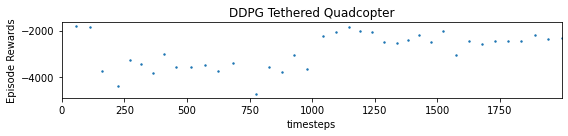

[INFO] BaseAviary.__init__() loaded parameters from the drone's .urdf:
[INFO] m 0.027000, L 0.039700,
[INFO] ixx 0.000014, iyy 0.000014, izz 0.000022,
[INFO] kf 0.000000, km 0.000000,
[INFO] t2w 2.250000, max_speed_kmh 30.000000,
[INFO] gnd_eff_coeff 11.368590, prop_radius 0.023135,
[INFO] drag_xy_coeff 0.000001, drag_z_coeff 0.000001,
[INFO] dw_coeff_1 2267.180000, dw_coeff_2 0.160000, dw_coeff_3 -0.110000
plugin= 4
[INFO] Max tether force set to  0.7144 N
0
[ 8.45474355e-02  3.41746734e-02  9.86563448e-01  2.78758462e-02
 -2.46497588e-02  3.24341668e-04 -2.19029027e-03 -9.73481185e-04
 -2.76254399e-02  1.82547924e-02  1.27876173e-02  3.48832671e-03
 -4.01009262e-01  9.47161913e-01 -9.21710610e-01  2.31261253e-02]
False
[WARNING] BaseAviary.render() is implemented as text-only, re-initialize the environment using Aviary(gui=True) to use PyBullet's graphical interface

[INFO] BaseAviary.render() ——— it 0001 ——— wall-clock time 0.1s, simulation time 0.0s@200Hz (0.07x)
[INFO] BaseAviary.

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


39
[ 0.05742878  0.00592343  0.4456476   0.91555292  0.42879743  0.2347678
 -0.03117114 -0.05580443 -0.98073362  0.11982766  0.12925834  0.02175031
 -0.26007068  0.30707765 -0.09503824  0.04299879]
False

[INFO] BaseAviary.render() ——— it 0040 ——— wall-clock time 0.2s, simulation time 0.2s@200Hz (1.00x)
[INFO] BaseAviary.render() ——— drone 0 ——— x +00.06, y +00.01, z +00.45 ——— velocity -00.16, -00.28, -04.90 ——— roll +54.93, pitch +25.73, yaw +42.26 ——— angular velocities +215.69, +232.67, +78.30 ——— 
40
[ 0.05663877  0.00448544  0.42039111  0.94482859  0.43151672  0.24126313
 -0.03160019 -0.05751976 -1.          0.11650197  0.13276618  0.02246234
 -0.31542599  0.32550108 -0.19236612  0.12433028]
False

[INFO] BaseAviary.render() ——— it 0041 ——— wall-clock time 0.2s, simulation time 0.2s@200Hz (1.01x)
[INFO] BaseAviary.render() ——— drone 0 ——— x +00.06, y +00.00, z +00.42 ——— velocity -00.16, -00.29, -05.05 ——— roll +56.69, pitch +25.89, yaw +43.43 ——— angular velocities +209.70, +238

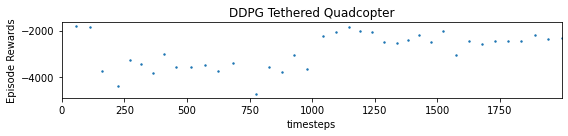

[INFO] BaseAviary.__init__() loaded parameters from the drone's .urdf:
[INFO] m 0.027000, L 0.039700,
[INFO] ixx 0.000014, iyy 0.000014, izz 0.000022,
[INFO] kf 0.000000, km 0.000000,
[INFO] t2w 2.250000, max_speed_kmh 30.000000,
[INFO] gnd_eff_coeff 11.368590, prop_radius 0.023135,
[INFO] drag_xy_coeff 0.000001, drag_z_coeff 0.000001,
[INFO] dw_coeff_1 2267.180000, dw_coeff_2 0.160000, dw_coeff_3 -0.110000
plugin= 4
[INFO] Max tether force set to  0.7144 N
0
[-5.17070175e-02 -1.83509423e-01  8.92554547e-01 -5.67010643e-02
  1.96907745e-02  2.55088145e-04  1.52317398e-03  5.33941176e-03
 -3.16567971e-02 -9.44414030e-03 -9.74189568e-03  2.65191889e-03
 -8.05334508e-01 -9.32583094e-01 -9.09039497e-01  7.49114156e-01]
False
[WARNING] BaseAviary.render() is implemented as text-only, re-initialize the environment using Aviary(gui=True) to use PyBullet's graphical interface

[INFO] BaseAviary.render() ——— it 0001 ——— wall-clock time 0.1s, simulation time 0.0s@200Hz (0.08x)
[INFO] BaseAviary.

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


40
[-0.04251265 -0.13240835  0.52985758 -0.22865375 -0.07836469  0.02481558
  0.0080172   0.08069776 -0.57284547 -0.01447635  0.03403648  0.01451486
 -0.00953478  0.0357976   0.25815189  0.16718817]
False

[INFO] BaseAviary.render() ——— it 0041 ——— wall-clock time 0.2s, simulation time 0.2s@200Hz (1.02x)
[INFO] BaseAviary.render() ——— drone 0 ——— x -00.04, y -00.13, z +00.53 ——— velocity +00.04, +00.40, -02.86 ——— roll -13.72, pitch -04.70, yaw +04.47 ——— angular velocities -26.06, +61.27, +52.25 ——— 
41
[-0.04230967 -0.13034208  0.51524561 -0.2295851  -0.07425503  0.02620532
  0.00811912  0.08265091 -0.5844791  -0.00836273  0.02681434  0.01364957
 -0.01206541  0.03825891  0.28397238  0.20450568]
False

[INFO] BaseAviary.render() ——— it 0042 ——— wall-clock time 0.2s, simulation time 0.2s@200Hz (1.02x)
[INFO] BaseAviary.render() ——— drone 0 ——— x -00.04, y -00.13, z +00.52 ——— velocity +00.04, +00.41, -02.92 ——— roll -13.78, pitch -04.46, yaw +04.72 ——— angular velocities -15.05, +48.27

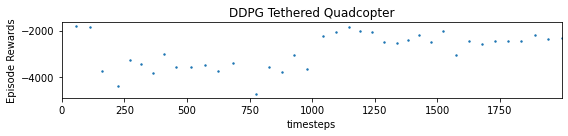

[INFO] BaseAviary.__init__() loaded parameters from the drone's .urdf:
[INFO] m 0.027000, L 0.039700,
[INFO] ixx 0.000014, iyy 0.000014, izz 0.000022,
[INFO] kf 0.000000, km 0.000000,
[INFO] t2w 2.250000, max_speed_kmh 30.000000,
[INFO] gnd_eff_coeff 11.368590, prop_radius 0.023135,
[INFO] drag_xy_coeff 0.000001, drag_z_coeff 0.000001,
[INFO] dw_coeff_1 2267.180000, dw_coeff_2 0.160000, dw_coeff_3 -0.110000
plugin= 4
[INFO] Max tether force set to  0.7144 N
0
[ 6.68208326e-02  8.56843982e-02  9.32679626e-01  7.29536656e-02
 -1.70344485e-02  3.14537660e-04 -1.93872120e-03 -2.85994896e-03
 -2.93019575e-02 -1.44470251e-02 -1.86318740e-02  3.02699736e-03
 -5.10613561e-01 -6.54674768e-01 -9.92681265e-01  9.89609003e-01]
False
[WARNING] BaseAviary.render() is implemented as text-only, re-initialize the environment using Aviary(gui=True) to use PyBullet's graphical interface

[INFO] BaseAviary.render() ——— it 0001 ——— wall-clock time 0.1s, simulation time 0.0s@200Hz (0.08x)
[INFO] BaseAviary.

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


20
[ 0.06185411  0.07725876  0.877172    0.24259597 -0.16819386 -0.0206315
 -0.02034794 -0.03309041 -0.15793649  0.10300828 -0.09583997 -0.01695925
  0.8000648  -0.02871543 -0.11609173 -0.15973413]
False

[INFO] BaseAviary.render() ——— it 0021 ——— wall-clock time 0.1s, simulation time 0.1s@200Hz (0.82x)
[INFO] BaseAviary.render() ——— drone 0 ——— x +00.06, y +00.08, z +00.88 ——— velocity -00.10, -00.17, -00.79 ——— roll +14.56, pitch -10.09, yaw -03.71 ——— angular velocities +185.41, -172.51, -61.05 ——— 
21
[ 0.06129878  0.07637017  0.87312881  0.26044712 -0.18183561 -0.02349817
 -0.02221332 -0.03554387 -0.16172762  0.11043568 -0.09882889 -0.01782068
  0.81096792 -0.00578111 -0.10574305 -0.18073213]
False

[INFO] BaseAviary.render() ——— it 0022 ——— wall-clock time 0.1s, simulation time 0.1s@200Hz (0.85x)
[INFO] BaseAviary.render() ——— drone 0 ——— x +00.06, y +00.08, z +00.87 ——— velocity -00.11, -00.18, -00.81 ——— roll +15.63, pitch -10.91, yaw -04.23 ——— angular velocities +198.78, -177

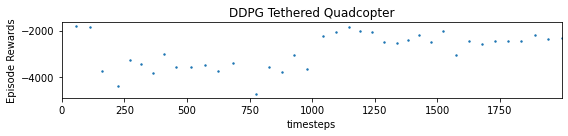

[INFO] BaseAviary.__init__() loaded parameters from the drone's .urdf:
[INFO] m 0.027000, L 0.039700,
[INFO] ixx 0.000014, iyy 0.000014, izz 0.000022,
[INFO] kf 0.000000, km 0.000000,
[INFO] t2w 2.250000, max_speed_kmh 30.000000,
[INFO] gnd_eff_coeff 11.368590, prop_radius 0.023135,
[INFO] drag_xy_coeff 0.000001, drag_z_coeff 0.000001,
[INFO] dw_coeff_1 2267.180000, dw_coeff_2 0.160000, dw_coeff_3 -0.110000
plugin= 4
[INFO] Max tether force set to  0.7144 N
0
[-1.13551527e-01  1.75357177e-01  9.29414551e-01 -7.19244778e-02
 -8.50692579e-02  2.14777139e-04  3.77800907e-04 -7.71483931e-04
 -1.20450589e-02 -5.80003382e-03 -6.61775441e-03  1.89015913e-03
 -6.73299253e-01  2.76160002e-01  7.34597445e-02 -1.71737075e-02]
False
[WARNING] BaseAviary.render() is implemented as text-only, re-initialize the environment using Aviary(gui=True) to use PyBullet's graphical interface

[INFO] BaseAviary.render() ——— it 0001 ——— wall-clock time 0.1s, simulation time 0.0s@200Hz (0.08x)
[INFO] BaseAviary.

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


21
[-0.11153006  0.17130652  0.86354718 -0.11909509 -0.0050392   0.04005063
  0.00589465 -0.00890807 -0.20875699  0.00486587  0.02007589  0.04232687
 -0.34963083 -0.07251501  0.02114153 -0.05439776]
False

[INFO] BaseAviary.render() ——— it 0022 ——— wall-clock time 0.1s, simulation time 0.1s@200Hz (0.83x)
[INFO] BaseAviary.render() ——— drone 0 ——— x -00.11, y +00.17, z +00.86 ——— velocity +00.03, -00.04, -01.04 ——— roll -07.15, pitch -00.30, yaw +07.21 ——— angular velocities +08.76, +36.14, +152.38 ——— 
22
[-0.11138046  0.17109249  0.85817843 -0.11754122 -0.00261653  0.04454513
  0.00598406 -0.00856101 -0.21474975  0.00812787  0.0173814   0.04496577
 -0.33540606 -0.07363677  0.02014756 -0.04751122]
False

[INFO] BaseAviary.render() ——— it 0023 ——— wall-clock time 0.1s, simulation time 0.1s@200Hz (0.85x)
[INFO] BaseAviary.render() ——— drone 0 ——— x -00.11, y +00.17, z +00.86 ——— velocity +00.03, -00.04, -01.07 ——— roll -07.05, pitch -00.16, yaw +08.02 ——— angular velocities +14.63, +31.2

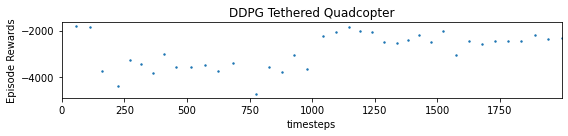

[INFO] BaseAviary.__init__() loaded parameters from the drone's .urdf:
[INFO] m 0.027000, L 0.039700,
[INFO] ixx 0.000014, iyy 0.000014, izz 0.000022,
[INFO] kf 0.000000, km 0.000000,
[INFO] t2w 2.250000, max_speed_kmh 30.000000,
[INFO] gnd_eff_coeff 11.368590, prop_radius 0.023135,
[INFO] drag_xy_coeff 0.000001, drag_z_coeff 0.000001,
[INFO] dw_coeff_1 2267.180000, dw_coeff_2 0.160000, dw_coeff_3 -0.110000
plugin= 4
[INFO] Max tether force set to  0.7144 N
0
[ 1.92388539e-01  1.96486436e-01  1.00000000e+00  8.54816207e-02
  3.53040251e-02  8.47599243e-05 -1.66820614e-03 -2.83458544e-03
 -1.26328524e-02 -1.20490560e-03 -3.11761586e-03  8.70037668e-04
 -9.17708874e-02  6.32671714e-01 -1.53438389e-01  7.21707344e-01]
False
[WARNING] BaseAviary.render() is implemented as text-only, re-initialize the environment using Aviary(gui=True) to use PyBullet's graphical interface

[INFO] BaseAviary.render() ——— it 0001 ——— wall-clock time 0.1s, simulation time 0.0s@200Hz (0.09x)
[INFO] BaseAviary.

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))




[INFO] BaseAviary.render() ——— it 0021 ——— wall-clock time 0.1s, simulation time 0.1s@200Hz (0.77x)
[INFO] BaseAviary.render() ——— drone 0 ——— x +00.19, y +00.19, z +01.05 ——— velocity -00.07, -00.13, -01.11 ——— roll +01.77, pitch -00.88, yaw +07.30 ——— angular velocities -122.80, -113.95, +109.14 ——— 
21
[ 0.18593971  0.18612575  1.          0.01723673 -0.02338052  0.04374302
 -0.01474308 -0.02609606 -0.22982838 -0.07382202 -0.06849215  0.03096792
  0.22230935  0.19456828 -0.44833636 -0.12894303]
False

[INFO] BaseAviary.render() ——— it 0022 ——— wall-clock time 0.1s, simulation time 0.1s@200Hz (0.80x)
[INFO] BaseAviary.render() ——— drone 0 ——— x +00.19, y +00.19, z +01.04 ——— velocity -00.07, -00.13, -01.15 ——— roll +01.03, pitch -01.40, yaw +07.87 ——— angular velocities -132.88, -123.29, +111.48 ——— 
22
[ 0.1855671   0.18546782  1.          0.00386982 -0.03260692  0.04703355
 -0.01490411 -0.02631689 -0.23725933 -0.07943023 -0.07354267  0.03159852
  0.20745587  0.18945193 -0.4421756

In [16]:
if __name__ == "__main__":

    #### Check the environment's spaces ################################################################
    #env = gym.make("rl-CrazyFlie-aviary-v0")
    env = RLTetherAviary(gui=0, record=0)
    env = Monitor(env, log_dir)
    print("[INFO] Action space:", env.action_space)
    print("[INFO] Observation space:", env.observation_space)
    # print("[INFO] Checking Environment...")
    # check_env(env, warn=True, skip_render_check=True) 

    #### Train the model ###############################################################################
    n_actions = env.action_space.shape[-1]
    #action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions), dt = 0.005)
    callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
    model = DDPG(MlpPolicy, env, verbose=1, batch_size=64, action_noise=action_noise)

    training_timesteps = 200000
    
    for i in range(10):
    
        # print("Iteration\t", i)

        model.learn(total_timesteps=training_timesteps)
        model.save("ddpg"+str((i+1)*training_timesteps))
        model.save_replay_buffer("ddpg_experience"+str((i+1)*training_timesteps))
        results_plotter.plot_results([log_dir], training_timesteps, results_plotter.X_TIMESTEPS, "DDPG Tethered Quadcopter")
        plt.show()

        #### Show (and record a video of) the model's performance ##########################################
        env_test = RLTetherAviary(gui=0, record=0)
        obs = env_test.reset()
        start = time.time()
        for i in range(10*env_test.SIM_FREQ):
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env_test.step(action)
            print(i)
            print(obs)
            print(done)
            env_test.render()
            if done: break
        env_test.close()

    env.close()